In [2]:
import pandas as pd
import geopandas as gpd
from sklearn.neighbors import KDTree
import numpy as np
import statsmodels
import numpy.linalg as la
import matplotlib.pyplot as plt
import btbpy as btb

In [3]:
def orthogonalize(U, eps=1e-15):
    """
    from https://gist.github.com/anmolkabra/b95b8e7fb7a6ff12ba5d120b6d9d1937
    """
    n = len(U[0])
    V = U.T
    for i in range(n):
        prev_basis = V[0:i]     # orthonormal basis before V[i]
        coeff_vec = np.dot(prev_basis, V[i].T)  # each entry is np.dot(V[j], V[i]) for all j < i 
        V[i] -= np.dot(coeff_vec, prev_basis).T
        if la.norm(V[i]) < eps:
            V[i][V[i] < eps] = 0.   # set the small entries to 0
        else:
            V[i] /= la.norm(V[i])
    return V.T

In [4]:
points_c = pd.read_parquet('coord_france_indif_indus_remar_concentrated.parquet.gzip')

In [5]:
points_d = pd.read_parquet('coord_france_indif_indus_remar_dispersed.parquet.gzip')

<Axes: xlabel='x', ylabel='y'>

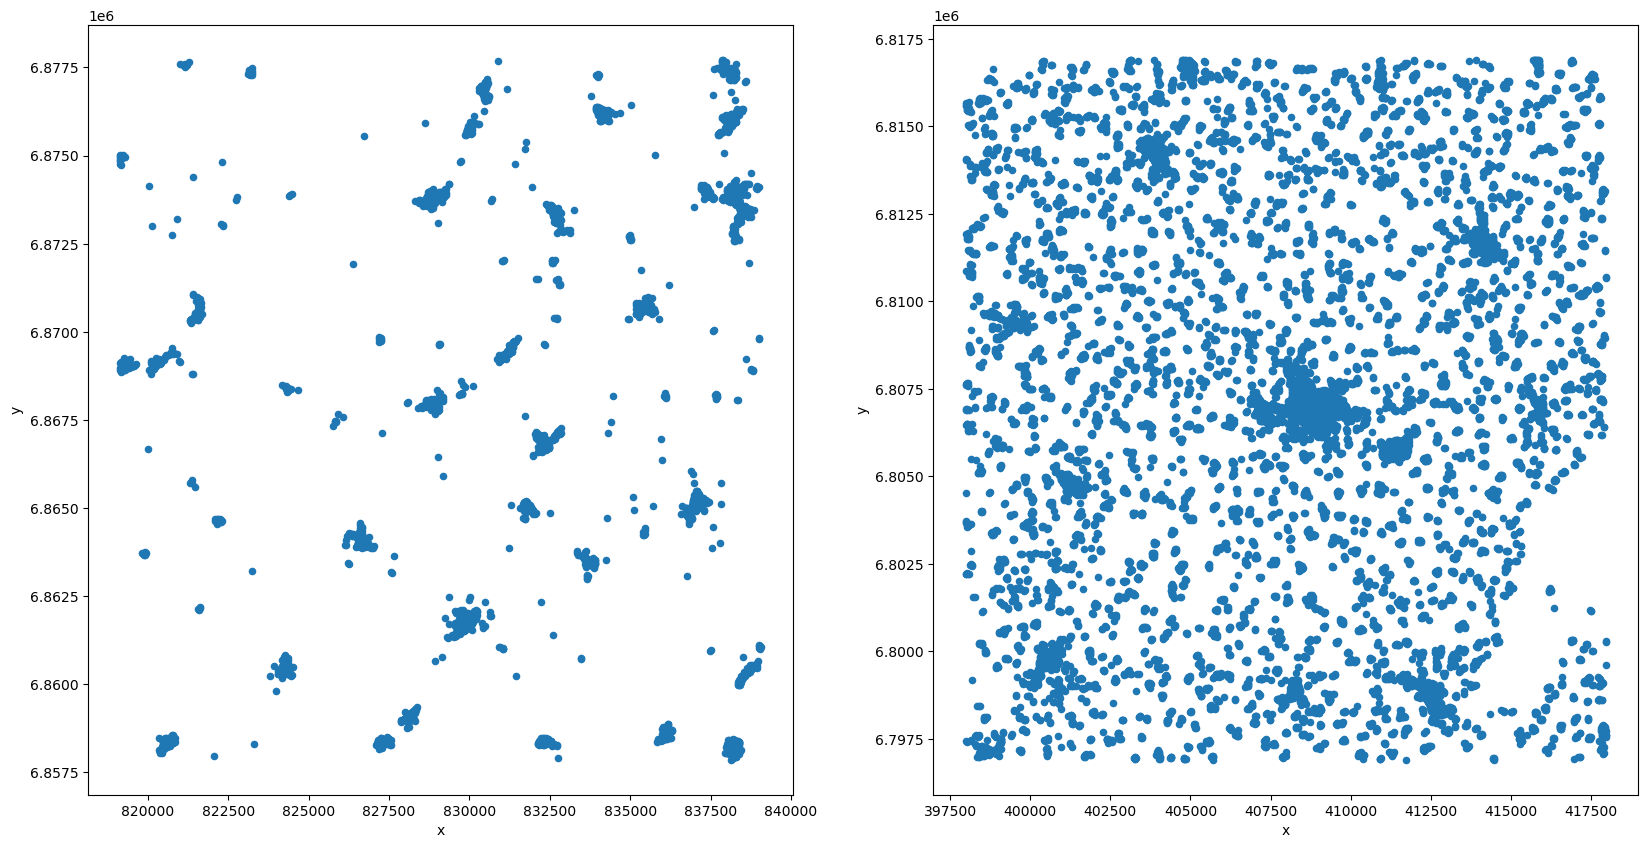

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
points_c.plot.scatter('x','y', ax=ax1)
points_d.plot.scatter('x','y', ax=ax2)

Nos rayons

In [7]:
radius=np.array([50,100,200,400,800])

On calcule le nombre de voisins puis l'inverse pour estimer par la méthode de sandbox la dimension de boxcounting

In [8]:
neighbors=np.zeros((points_c.shape[0],radius.size),dtype=float)
tree = KDTree(points_c)
for i in range(radius.size):
    neighbors[:,i]=tree.query_radius(points_c,r= radius[i],count_only=True,return_distance=False)
    output=np.column_stack([points_c,neighbors])
    names=np.hstack([['x','y'], np.core.defchararray.add('r_',np.char.mod('%d', radius))])
output_c=pd.DataFrame(output,columns=names)


sdbc_c = (output_c[['r_50', 'r_100', 'r_200', 'r_400', 'r_800']]**-1).sum(0)**-1

/tmp/ipykernel_1014/1360773243.py:6: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.defchararray.
  names=np.hstack([['x','y'], np.core.defchararray.add('r_',np.char.mod('%d', radius))])
/tmp/ipykernel_1014/1360773243.py:6: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. 

In [9]:
neighbors=np.zeros((points_d.shape[0],radius.size),dtype=float)
tree = KDTree(points_d)
for i in range(radius.size):
    neighbors[:,i]=tree.query_radius(points_d,r= radius[i],count_only=True,return_distance=False)
    output=np.column_stack([points_d,neighbors])
    names=np.hstack([['x','y'], np.core.defchararray.add('r_',np.char.mod('%d', radius))])
output_d=pd.DataFrame(output,columns=names)


sdbc_d = (output_d[['r_50', 'r_100', 'r_200', 'r_400', 'r_800']]**-1).sum(0)**-1

/tmp/ipykernel_1014/3412187582.py:6: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.defchararray.
  names=np.hstack([['x','y'], np.core.defchararray.add('r_',np.char.mod('%d', radius))])
/tmp/ipykernel_1014/3412187582.py:6: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. 

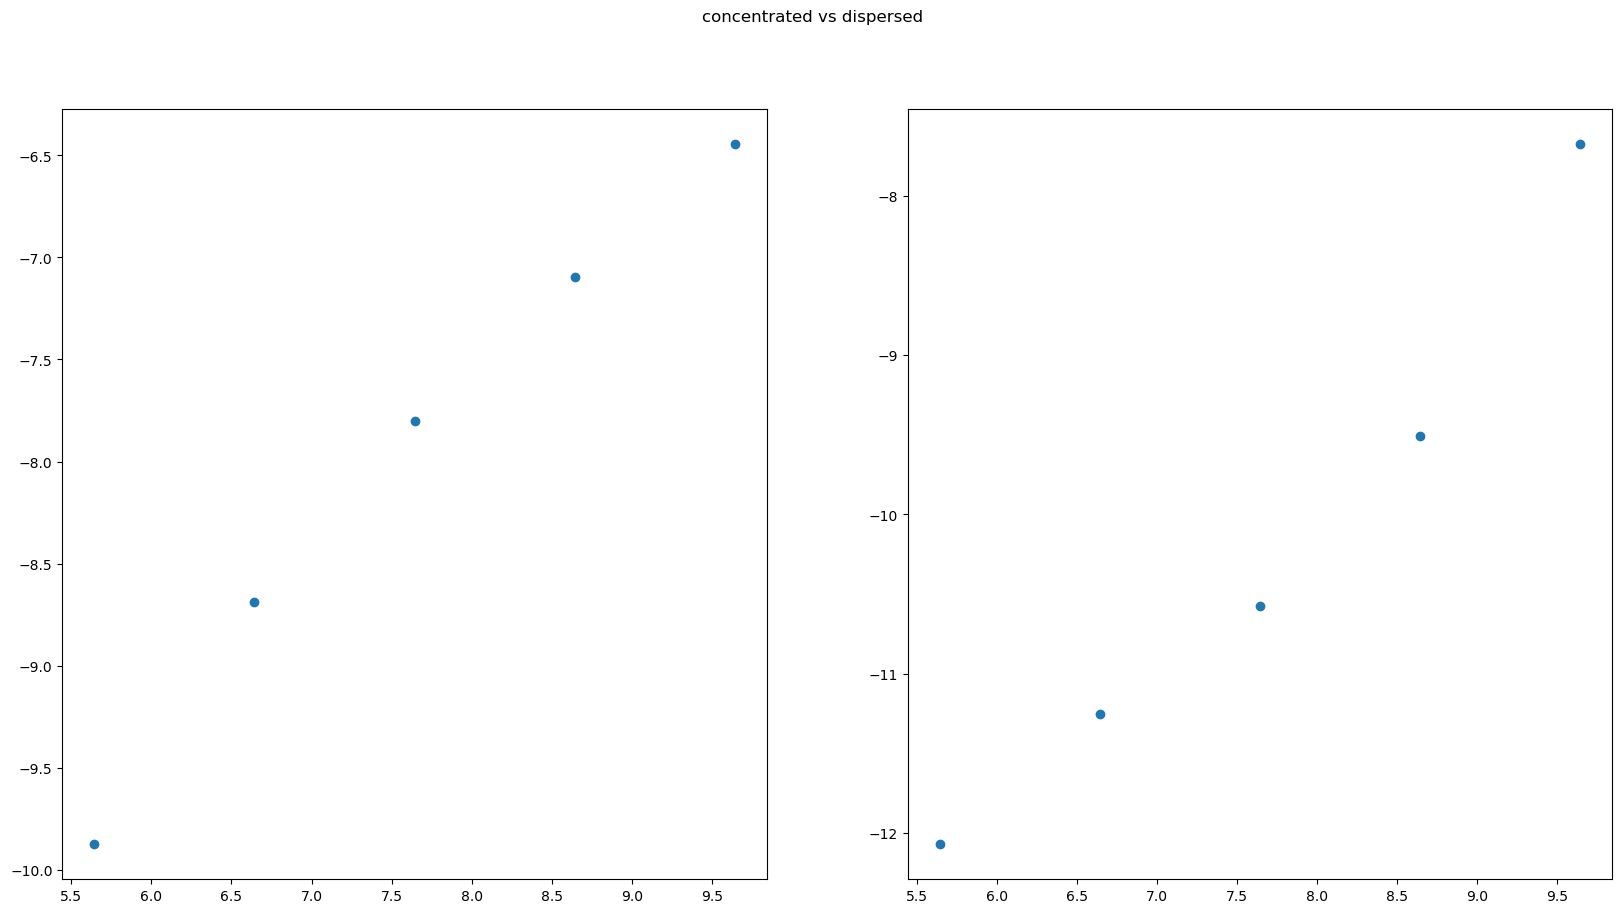

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('concentrated vs dispersed')
ax1.scatter(np.log2(radius), np.log2(sdbc_c))
ax2.scatter(np.log2(radius), np.log2(sdbc_d))

On obtient par cette régression les coeffs,a0, a1 et a2 de a0 + a1 * log(s) + a2 * log(s)^2. Comme les polygones sont normalisés a1 n'est pas directement la dimension fractale mais est a1=k*D. a2 est l'écart à l'invariance d'échelle. Le dernier coefficent est la dimension fractale.

In [108]:
poly2 = orthogonalize(np.concatenate([np.ones(len(radius)), np.log2(radius), np.log2(radius)**2]).reshape(3,len(radius)).T)
regresseur = np.log2(radius).reshape(len(radius),1)
regresseur = (regresseur - np.mean(regresseur)) / (np.var(regresseur) * radius.shape[0])
poly2 = np.concat([poly2, regresseur], axis=1) #regresseur permet de calculer la dimension fractale

In [109]:
np.matmul(np.log2(sdbc_c), poly2)

array([-17.84468604,   2.67170571,  -0.33714737,   0.84486753])

In [110]:
np.matmul(np.log2(sdbc_d), poly2)

array([-22.84596688,   3.33290428,   0.64754409,   1.05395688])

On fait à présent le calcul sur le Calvados élargi avec la gwfa

In [14]:
calvados = pd.read_parquet('coord_calvados_indif_indus_remar.parquet.gzip')

In [15]:
neighbors=np.zeros((calvados.shape[0],radius.size),dtype=float)
tree = KDTree(calvados)
for i in range(radius.size):
    neighbors[:,i]=tree.query_radius(calvados,r= radius[i],count_only=True,return_distance=False)
    output=np.column_stack([calvados,neighbors])
    names=np.hstack([['x','y'], np.core.defchararray.add('r_',np.char.mod('%d', radius))])
output_c=pd.DataFrame(output,columns=names)

/tmp/ipykernel_1014/4009715620.py:6: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.defchararray.
  names=np.hstack([['x','y'], np.core.defchararray.add('r_',np.char.mod('%d', radius))])
/tmp/ipykernel_1014/4009715620.py:6: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. 

In [16]:
output_c[['r_50', 'r_100', 'r_200', 'r_400', 'r_800']] = output_c[['r_50', 'r_100', 'r_200', 'r_400', 'r_800']]**-1

In [89]:
lissage = btb.kernelSmoothing(output_c, '2154', 1000, 8000)

-------------------------------------------------
number of asked cores : 1
-------------------------------------------------
start of smoothing loop
-------------------------------------------------
-------------------------------------------------
end of smoothing loop - duration time in seconds = 7.944347858428955
-------------------------------------------------
-------------------------------------------------
start of the final grid map cooking
-------------------------------------------------
	-------------------------------------------------
	start of making polygons
	-------------------------------------------------
	-------------------------------------------------
	end of making polygons - duration in seconds = 0.8759782314300537
	-------------------------------------------------
	start of saving geodataframe
	-------------------------------------------------
	-------------------------------------------------
	end of saving geodataframe - duration in seconds = 0.005045890808

/opt/conda/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [93]:
multiscale = -np.matmul(np.log2(lissage[['r_50', 'r_100', 'r_200', 'r_400', 'r_800']]), poly2)
multiscale.columns= ['a0', 'a1', 'a2', 'D0']

In [94]:
lissage = pd.concat([lissage, multiscale], axis=1)

In [132]:
# je calcule ici le R2 associé au calcul de la dimension fractal
lissage['R2'] = (lissage['D0'] / np.std(np.log2(lissage[['r_50', 'r_100', 'r_200', 'r_400', 'r_800']]), axis=1) * np.std(np.log2(radius)))**2 

/opt/conda/lib/python3.12/site-packages/mapclassify/classifiers.py:940: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/opt/conda/lib/python3.12/site-packages/mapclassify/classifiers.py:970: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 if adam == 0 else 1 - self.adcm / adam


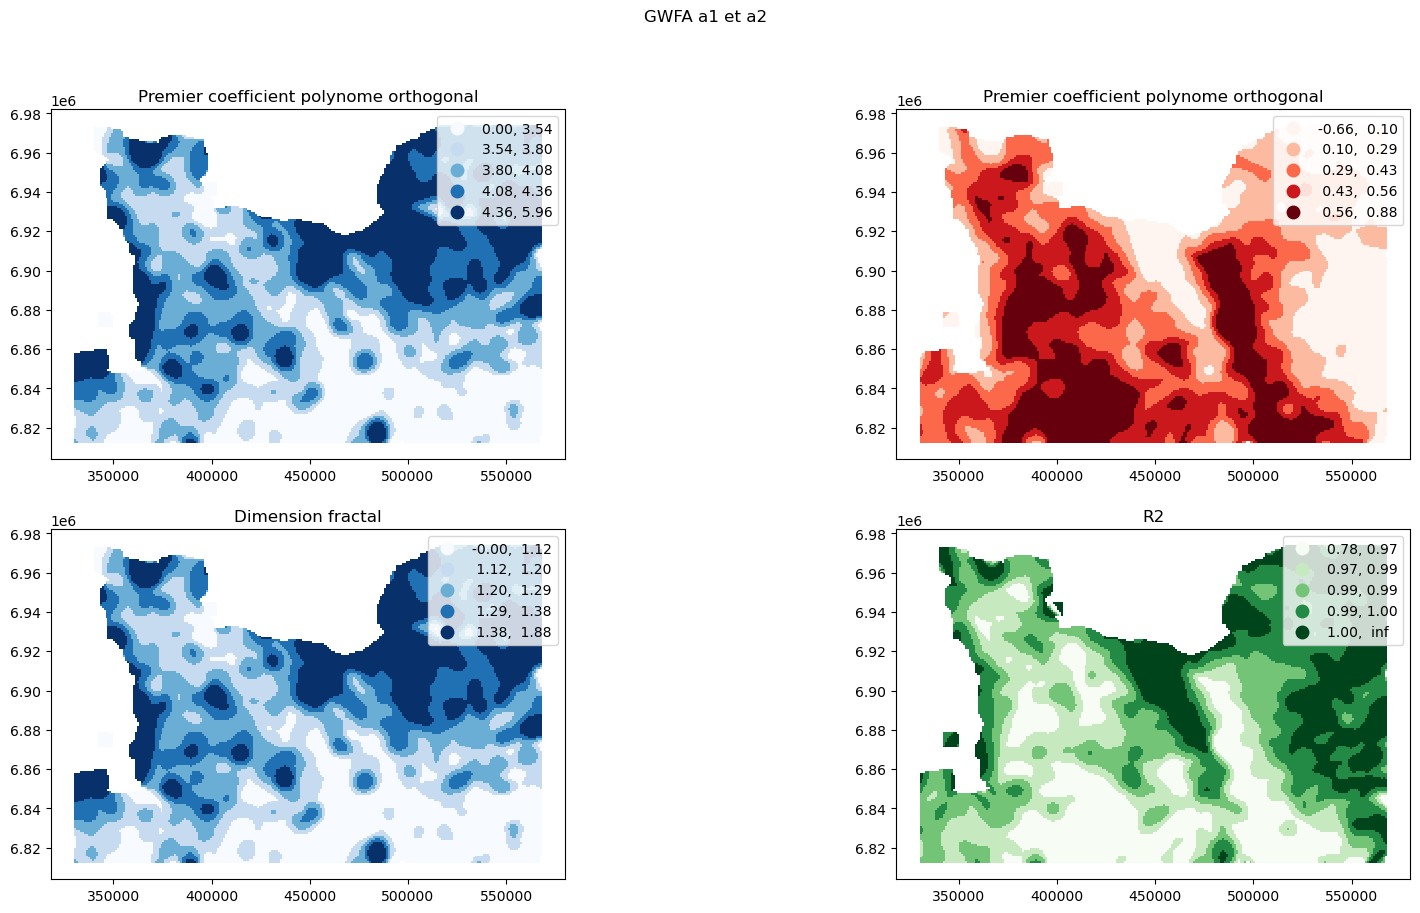

In [138]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
fig.suptitle('GWFA a1 et a2')
lissage.plot('a1', scheme='quantiles',  legend=True, ax=axs[0,0], cmap='Blues')
axs[0,0].title.set_text('Premier coefficient polynome orthogonal')
lissage.plot('a2', scheme='quantiles',  legend=True, ax=axs[0,1], cmap='Reds')
axs[0,1].title.set_text('Premier coefficient polynome orthogonal')
lissage.plot('D0', scheme='quantiles',  legend=True, ax=axs[1,0], cmap='Blues')
axs[1,0].title.set_text('Dimension fractal')
lissage.plot('R2', scheme='quantiles',  legend=True, ax=axs[1,1], cmap='Greens')
axs[1,1].title.set_text('R2')
